# Problem Set 7

<span style="color:red">Warning!</span> Some of the problems in this problem set require heavy computation - you are encouraged to start early so that you don't get stuck at the last minute.

# Face Recognition

Your goal for this problem set is to design a basic face recognition system. Since the machine learning force is now strong with you, the prompts for this problem set are deliberately vague. Be creative - but be careful! It my be useful to start by implementing this entire problem set on a relatively small subset of all of the images first, before using the full dataset.

## 1. Data Preprocessing and  Exploration

Download the "[Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)" data set from [this link](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (roughly 250MB).

### 1.1. Filter out people with few images

First, display a histogram that shows the number of images per individual (you may use log-scale if you like). Which individual has the most images from your dataset? 

Now, remove all individuals for whom you have fewer than 10 images. How many individuals are you left with in the dataset?

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import random

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.regularizers import l1, l2
import tensorflow as tf

In [2]:
# get the names
image_root = './lfw_funneled'
names = [item for item in os.listdir(image_root) if os.path.isdir(os.path.join(image_root, item))]

# get the number of images
n_images = np.zeros(len(names))
for i in range(len(names)):
    DIR = image_root + '/' + names[i]
    n_images[i] = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
    
# create the dataframe
image_df = pd.DataFrame({'name':names, 'n':n_images})
image_df.sort_values('name', inplace=True)
image_df.reset_index(drop=True, inplace=True)

George_W_Bush has the most images, with 530.0 images.


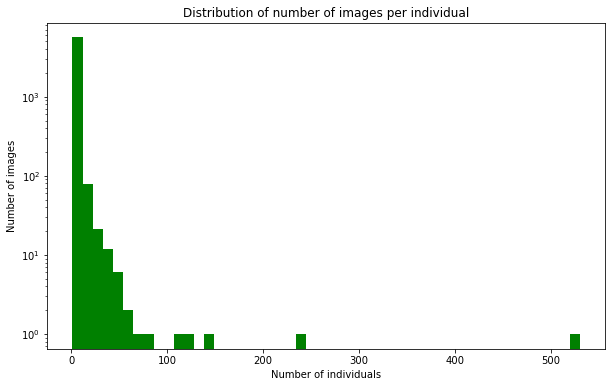

In [3]:
max_ind = image_df['n'].idxmax()
print(image_df['name'][max_ind] + ' has the most images, with ' + str(image_df['n'][max_ind]) + ' images.')

plt.figure(figsize=(10,6))

plt.hist(image_df['n'],bins=50, log=True, color = 'green')
plt.xlabel('Number of individuals')
plt.ylabel('Number of images')
plt.title('Distribution of number of images per individual')
plt.show()

In [4]:
image_df = image_df[image_df['n']>=10]
image_df.reset_index(drop=True, inplace=True)
print('number of remaining people = {}'.format(len(image_df.index)))
print('number of remaining images = {}'.format(np.sum(image_df['n'])))

number of remaining people = 158
number of remaining images = 4324.0


1. George_W_Bush has the most images, with 530.0 images.
2. number of remaining people = 158
3. number of remaining images = 4324

### 1.2. Show some faces!

1. Pick 10 random images from the dataset and display them in a 2 x 5 grid.
2. This time pick 200 random images. Create a single image that shows the "average face" over this random sample -- i.e. each pixel should display the average value of that particular pixel across the random sample. 

### 10 random images

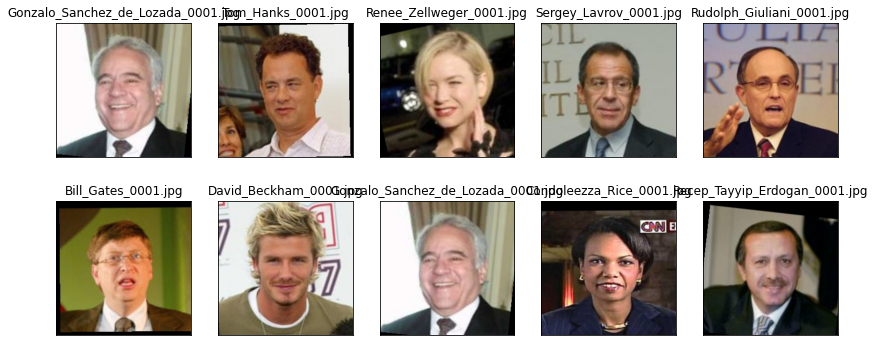

In [5]:
# pick 10 random people
random_10 = np.random.choice(image_df['name'], 10)

# plot them individually
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(14,6))

ax = ax.flatten()

for i in range(len(random_10)):
    img = mpimg.imread(image_root+'/'+random_10[i]+'/'+random_10[i]+'_0001.jpg')
    ax[i].imshow(img)
    ax[i].set_title(random_10[i]+'_0001.jpg')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

### Average face of 200 random images

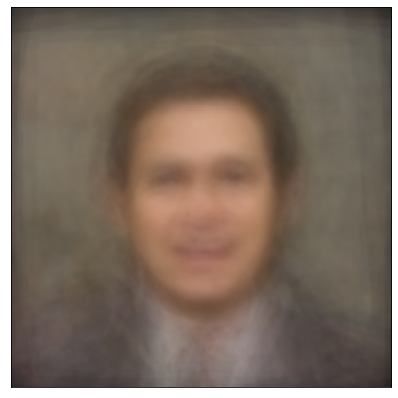

In [6]:
# get all the arrays for the 200 faces
random_200 = np.random.choice(image_df['name'], 200)

face_arrays = []
for i in range(len(random_200)):
    img = mpimg.imread(image_root+'/'+random_200[i]+'/'+random_200[i]+'_0001.jpg')
    face_arrays.append(img)

# compute the average face (divide by 255 because imshow requires floats to be between 0 and 1)
avg_face = np.mean(face_arrays, axis=0)
avg_face = avg_face/255

# plot
fig, ax = plt.subplots(figsize=(7,7))

ax.imshow(avg_face)
ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)

## 2. k-Means Clustering


### 2.1. Implementation

Implement the k-Means clustering algorithm that we discussed in class, using the Euclidean distance function. This will require that you define three new functions:
1. InitializeCentroids(X, k)
2. FindClosestCentroids(X, centroids)
3. ComputeCentroidMeans(X, centroids, k)

*Hint:* You may find  the [`pairwise_distances_argmin`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html) function useful.

In [7]:
# import helpful module
from sklearn.metrics import pairwise_distances_argmin

### InitializeCentroids
def InitializeCentroids(X, k):
    """
    Initialize centroids for k-Means clustering.
    
    Parameters
    ----------
    X : numpy array
        Data.
    
    k : int
        Number of centroids.
        
    Returns
    -------
    centroids : numpy array
        Coordinates of the centroids.
    """
    # just randomly pick k of the data rows to be the initial centroids
    rows = np.random.choice(np.shape(X)[0], k, replace=False)
    centroids = X[rows].copy()
    
    return centroids

### FindClosestCentroids
def FindClosestCentroids(X, centroids):
    """
    Find closest centroids for k-Means clustering.
    
    Parameters
    ----------
    X : numpy array
        Data.
    
    centroids : numpy array
        Coordinates of the centroids.
        
    Returns
    -------
    idx : numpy array
        Assigned centroids (cluster) for the data.
    """
    # yay for built-in functions
    idx = pairwise_distances_argmin(X, centroids, metric='euclidean')
    
    return idx

### ComputeCentroidMeans
def ComputeCentroidMeans(X, centroids, idx, k):
    """
    Compute centroid means for k-Means clustering.
    
    Parameters
    ----------
    X : numpy array
        Data.
        
    centroids : numpy array
        Coordinates of the centroids.
    
    idx : numpy array
        Assigned centroids (cluster) for the data.
        
    k : int
        Number of centroids.
        
    Returns
    -------
    new_centroids : numpy array
        Coordinates of the updated centroids.
    """
    # initialize new centroids
    new_centroids = np.zeros(np.shape(centroids))
    
    # iterate through each cluster
    for i in range(k):
        
        # pull out points in that cluster
        this_X = X[idx==i]
        
        # compute the mean
        new_centroid = np.mean(this_X, axis=0)
        
        # store
        new_centroids[i] = new_centroid
        
    return new_centroids

### ClusterKM
def ClusterKM(X, k):
    """
    k-Means clustering.
    
    Parameters
    ----------
    X : numpy array
        Data.
        
    k : int
        Number of centroids.
        
    Returns
    -------
    centroids : numpy array
        Coordinates of the centroids.
        
    idx : numpy array
        Assigned centroids (cluster) for the data.
    """
    # randomly choose clusters
    centroids = InitializeCentroids(X, k)
    
    # keep looping until convergence
    while True:
        
        # assign labels based on closest center
        idx = FindClosestCentroids(X, centroids)
        new_centroids = ComputeCentroidMeans(X, centroids, idx, k)

        # check for convergence
        if np.all(centroids == new_centroids):
            break
        else:
            centroids = new_centroids
    
    return centroids, idx

### 2.2. Sanity check

Apply your k-Means algorithm to a toy dataset to make sure it works properly. Also create a scatterplot that shows these datapoints, colored by cluster. 

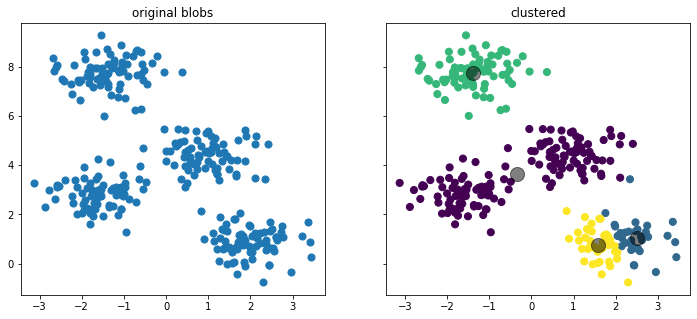

In [8]:
# import necessary module
from sklearn.datasets import make_blobs

# make blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

# cluster
myCenters, myIdx = ClusterKM(X, 4)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,5))

ax[0].scatter(X[:, 0], X[:, 1], s=50)
ax[0].set_title('original blobs')

ax[1].scatter(X[:, 0], X[:, 1], c=myIdx, s=50, cmap='viridis')
ax[1].scatter(myCenters[:, 0], myCenters[:, 1], c='black', s=200, alpha=0.5)
ax[1].set_title('clustered')

plt.show(fig)

### 2.3. Image centroids
Apply your k-Means algorithm to the images dataset, using k=10. Make sure to standardize your data first! Show a 10 x 2 grid of images where the first column contains (a) the image that represents the centroid for each of those clusters, and the second column contains (b) the closest image in the original dataset to that centroid. Use Euclidean distance. What do you notice?

*Note:* As you may notice, there are 250x250x3 = 187500 features for each image. If your k-Means algorithm is not implemented efficiently -- and even if it is -- it might take a long time for your algorithm to converge. If your computer is slow, it might even take a very long time for you to simply standardize your data. We recommend you convert your RGB images into grayscale first (using, for instance, the [`rgb2grey`](http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey) function, or any other way to convert to graysacle) before standardizing.



In [9]:
# # Convert image data to numpy array
# #Reading all Images
# from skimage import io

# all_data = []
# for i in range(len(image_df['name'])):
#     person=image_df['name'][i]
#     req_dir = image_root + '/' + person
#     imageList = [name for name in os.listdir(req_dir)]
#     for image_name in imageList:
#         all_data.append(io.imread(os.path.join(req_dir, image_name)))

# all_data = np.array(all_data[1:]) # convert list to array

In [10]:
# import sklearn
# from skimage.color import rgb2gray

# # Convert data to greyscale
# gr_all_data = rgb2gray(all_data)

# # Normalize all data; remember to vecorize dataset first
# norm_all_data, norm = sklearn.preprocessing.normalize(gr_all_data.reshape(gr_all_data.shape[0],-1), axis=1, copy=True, return_norm=True)

# # Apply K-Means algorithm, where k=10
# centroids, idx = ClusterKM(X=norm_all_data, k=10)

In [11]:
# # Build a list of centroids images
# cents = []
# for data in centroids:
#     img = data.reshape(250,250)
#     cents.append(img)

# # Build a dictionary for clusters, key as cluster label, value as imgs
# clusters = {}
# for i in range(len(cents)):
#     idx = np.where(idx==i)[0]
#     clusters[i] = norm_all_data[idx]

# # Find the closest image in each cluster to the respective centroid
# closest = []
# for i in range(len(cents)):
#     dist = np.sum((clusters[i].reshape(clusters[i].shape[0],250,250) - cents[i])**2)
#     closest_idx = np.argmin(dist)
#     closest.append(clusters[i][closest_idx].reshape(250,250))
    
# # Display in a 20 x 2 grid; 
# # Left column is image of centroid in each of 20 clusters, right column is image of closest image to the centroid
# _, axs = plt.subplots(10,2, figsize=(5,50)) 

# for i in range(10):
#     axs[i,0].imshow(cents[i])
#     axs[i,1].imshow(closest[i])

# plt.show()

In [12]:
# initialize the array
X = np.zeros((int(np.sum(image_df['n'])), 250*250*3))

# row counter
row = 0

# iterate through the names
for i in range(len(image_df.index)):
    
    # iterate through the images for that person
    for j in range(int(image_df['n'][i])):
        
        # get necessary strings (formatted correctly)
        name_str = image_df['name'][i]
        n_str = str(j+1).zfill(4)
        
        # get the image
        img = mpimg.imread(image_root+'/'+name_str+'/'+name_str+'_'+n_str+'.jpg')
        
        # divide by 255, then normalize
        img = img/255
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        
        # reshape it
        img = img.reshape(250*250*3)
        
        # store it
        X[row] = img
        
        # tick the row
        row = row + 1

In [13]:
refresh = False

if refresh:
    centroids, idx = ClusterKM(X, 10)
    np.savetxt('centroids.txt',centroids)
    np.savetxt('idx.txt',idx)
else:
    centroids = np.loadtxt('centroids.txt')
    idx = np.loadtxt('idx.txt')

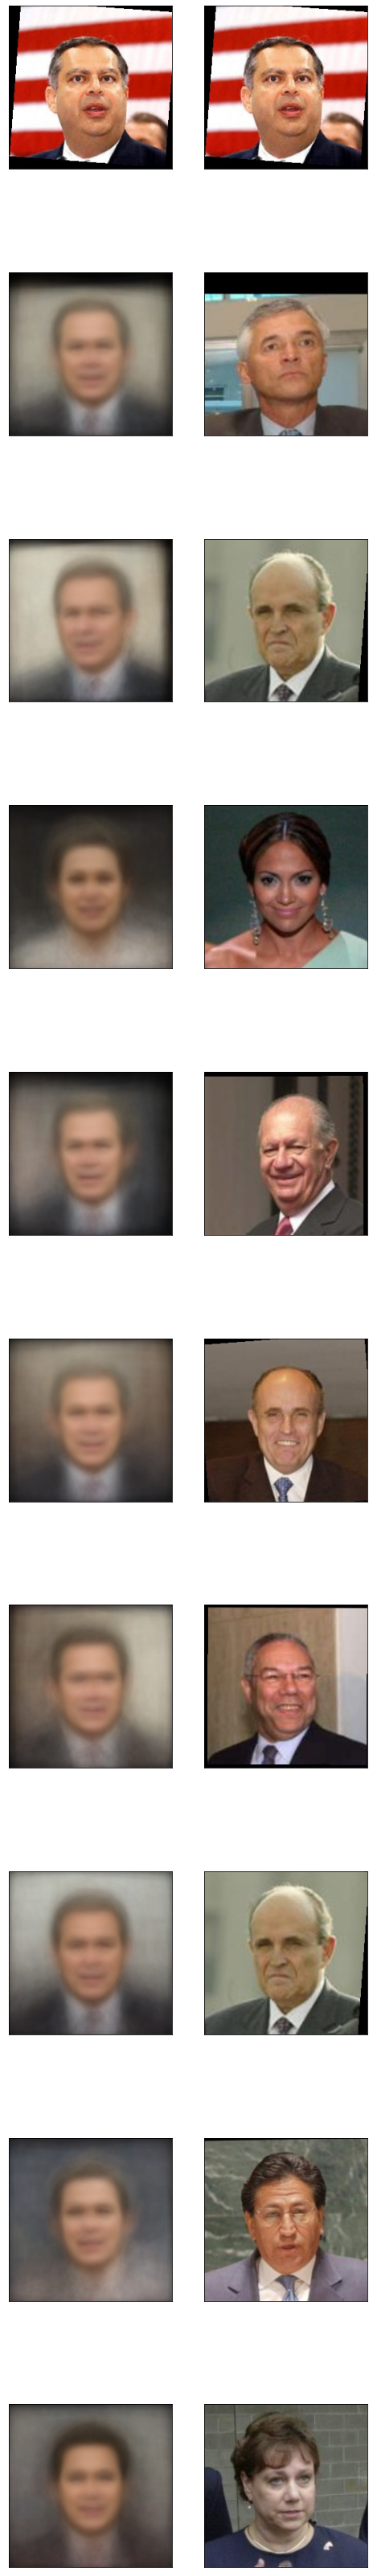

In [14]:
# find the closest neighbours
closest_neighbours = pairwise_distances_argmin(centroids, X, metric='euclidean')

# plot
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(8,60))

for i in range(10):
    ax[i][0].imshow(centroids[i].reshape(250, 250, 3))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    
    ax[i][1].imshow(X[closest_neighbours[i]].reshape(250,250,3))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    
plt.show(fig)

### Disussion 
It is observed that the closest image in the original dataset to a centroid is same /almost similar to image that represents the centroid for that cluster majority of the times.


In general, the centroid images all appear to display a vague, generic white male wearing a suit and tie. However, the shade of the background is noticably different between each centroid image. Furthermore, when we compare the centroid image to its nearest neighbour, we notice that the background matches well with the background of the centroid image (including black borders resulting from cropping/rotating the image to center the face), but the actual face need not.

This clearly illustrates that the current implementation of k-Means clustering is more sensitive to the background of the image, rather than face itself. Intuitively, this makes sense, because human faces are much more similar to one another than backgrounds are (e.g. we all have eyes, noses, mouths, etc, and our complexions are generally limited to a small range). Therefore, when trying to cluster the images, the method picks up on the greatest differences between the images (as it is supposed to), and this happens to be the backgrounds.

### 2.4 Classify yourself

Take a picture of yourself and scale it so that it is in a similar format to the images in the dataset. Show four images:
 1. The image of yourself.
 2. The cluster centroid closest to that image.
 3. The closest image in the dataset to that cluster centroid.
 4. The closest image in the dataset to the image of yourself.


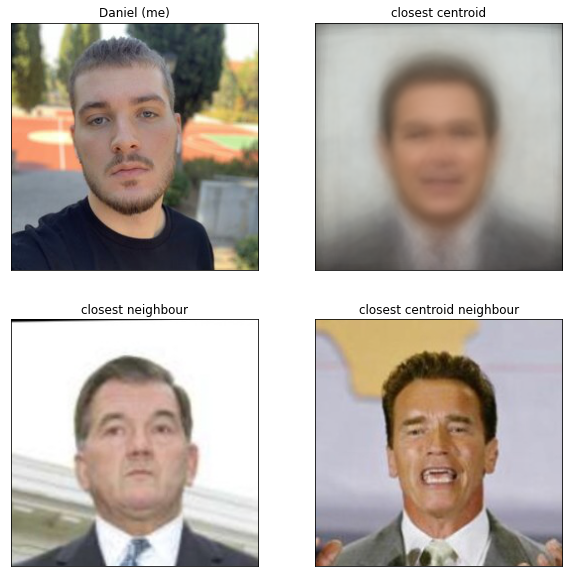

In [15]:
# read myself in, reshaping
daniel = mpimg.imread('daniel.jpg')
daniel = daniel.reshape((1, 250*250*3))

# closest centroid
daniel_closest_centroid = pairwise_distances_argmin(daniel, centroids, metric='euclidean')

# closest image
daniel_closest_neighbour = pairwise_distances_argmin(daniel, X, metric='euclidean')

# plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()

ax[0].imshow(daniel.reshape(250,250,3))
ax[0].set_title('Daniel (me)')

ax[1].imshow(centroids[daniel_closest_centroid[0]].reshape(250,250,3))
ax[1].set_title('closest centroid')

ax[2].imshow(X[daniel_closest_neighbour[0]].reshape(250,250,3))
ax[2].set_title('closest neighbour')

ax[3].imshow(X[closest_neighbours[daniel_closest_centroid[0]]].reshape(250,250,3))
ax[3].set_title('closest centroid neighbour')

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show(fig)

## 3. PCA and Eigenfaces 

Ensure you are using standardized data. Then, set aside 50% of the images as "test" data and using the remaining images as "training" data.


### 3.1. How many components?

Run principal component analysis using [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) from sklearn on the training dataset. Create a figure showing how the amount of variance explained by your components increases as you increase the number of components from 1 to 100. How many components are required to explain 75% of the variation in your original data?

In [17]:
# get the training inds
train_inds = np.random.choice(np.shape(X)[0], int(np.shape(X)[0]/2), replace=False)
train_inds = np.sort(train_inds)

# get the testing inds
test_inds = np.array([], dtype=int)
for i in range(np.shape(X)[0]):
    if i not in train_inds:
        test_inds = np.append(test_inds, i)
        
# get the respective arrays
X_train = X[train_inds].copy()
X_test = X[test_inds].copy()

In [18]:
# import module
from sklearn.decomposition import PCA
    
# PCA
pca = PCA(n_components=100)
pca.fit(X_train)

PCA(n_components=100)

we pass 75% of the variance in the data with:
47 components
when we explain 75.09% of the variance


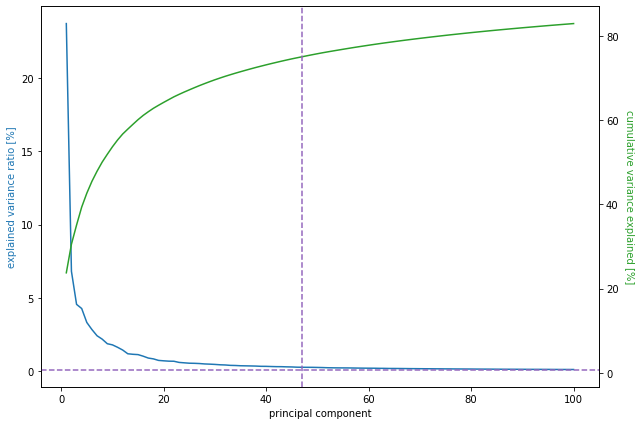

In [19]:
# when do we cross 75%?
ind_75 = np.argmax((np.cumsum(pca.explained_variance_ratio_)*100)>75)
print('we pass 75% of the variance in the data with:')
print('{} components'.format(ind_75+1))
print('when we explain {:.2f}% of the variance'.format(np.cumsum(pca.explained_variance_ratio_)[ind_75]*100))

# plot
fig, ax = plt.subplots(figsize=(10,7))

rects = ax.plot(np.arange(len(pca.explained_variance_ratio_))+1, pca.explained_variance_ratio_*100, color='C0')
ax.set_ylabel('explained variance ratio [%]', color='C0')
ax.set_xlabel('principal component')

twinax = ax.twinx()
twinax.plot(np.arange(len(pca.explained_variance_ratio_))+1,
            np.cumsum(pca.explained_variance_ratio_)*100, color='C2')
twinax.axhline(np.cumsum(pca.explained_variance_ratio_)[ind_75], ls='--', c='C4')
twinax.axvline(ind_75+1, ls='--', c='C4')
twinax.set_ylabel('cumulative variance explained [%]', rotation=270, color='C2', labelpad=15)

plt.show(fig)

*Your comments here*

### 3.2. The Eigenfaces

Extract the 10 first principal components (the "eigenfaces") and display them below.

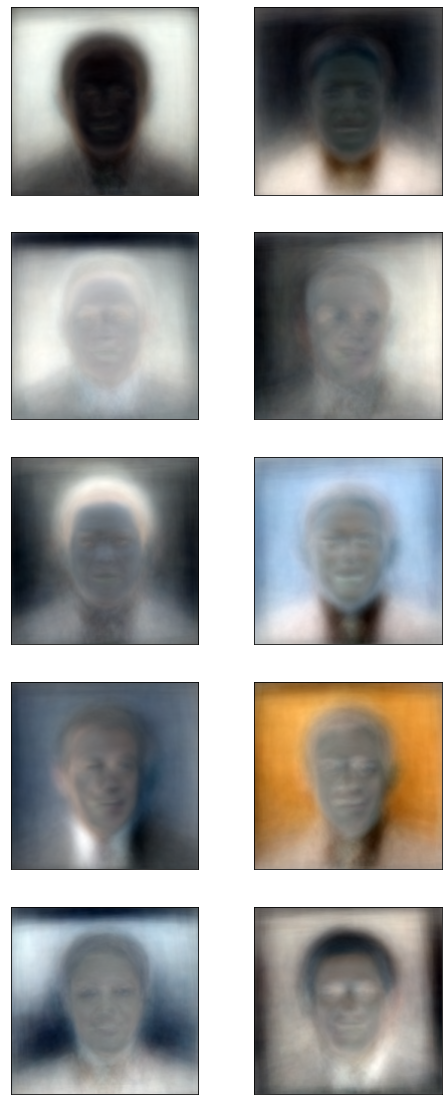

In [20]:
# get the first 10 components
pc_10 = pca.components_[:10].copy()

# normalize them to be in the range 0-1
for i in range(len(pc_10)):
    pc_10[i] = (pc_10[i] - np.min(pc_10[i])) / (np.max(pc_10[i]) - np.min(pc_10[i]))

# plot
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,20))
ax = ax.flatten()

for i in range(len(pc_10)):
    ax[i].imshow(pc_10[i].reshape(250,250,3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show(fig)

### 3.3. Projections, clustering and PCA
 - Project all of the training and test data into the 40-dimensional space defined by the first 40 principal components.
 - Apply k-means clustering, with k=16, to the 40-dimensional projections of the training data. 
 - Display a 4 x 4 grid of images that shows what each of the 16 centroids look like after the centroid is projected back into the original-image space.

In [21]:
# Projecting into 40-dimensional space
pc_40 = pca.components_[:40].copy()
X_train_40 = X_train.dot(pc_40.T)
X_test_40 = X_test.dot(pc_40.T)

In [22]:
# Apply K means Cluserting with 20 clusters
centroids_train_40, idx_train_40 = ClusterKM(X_train_40, 16)
centroids_train_40 = centroids_train_40.dot(pc_40)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


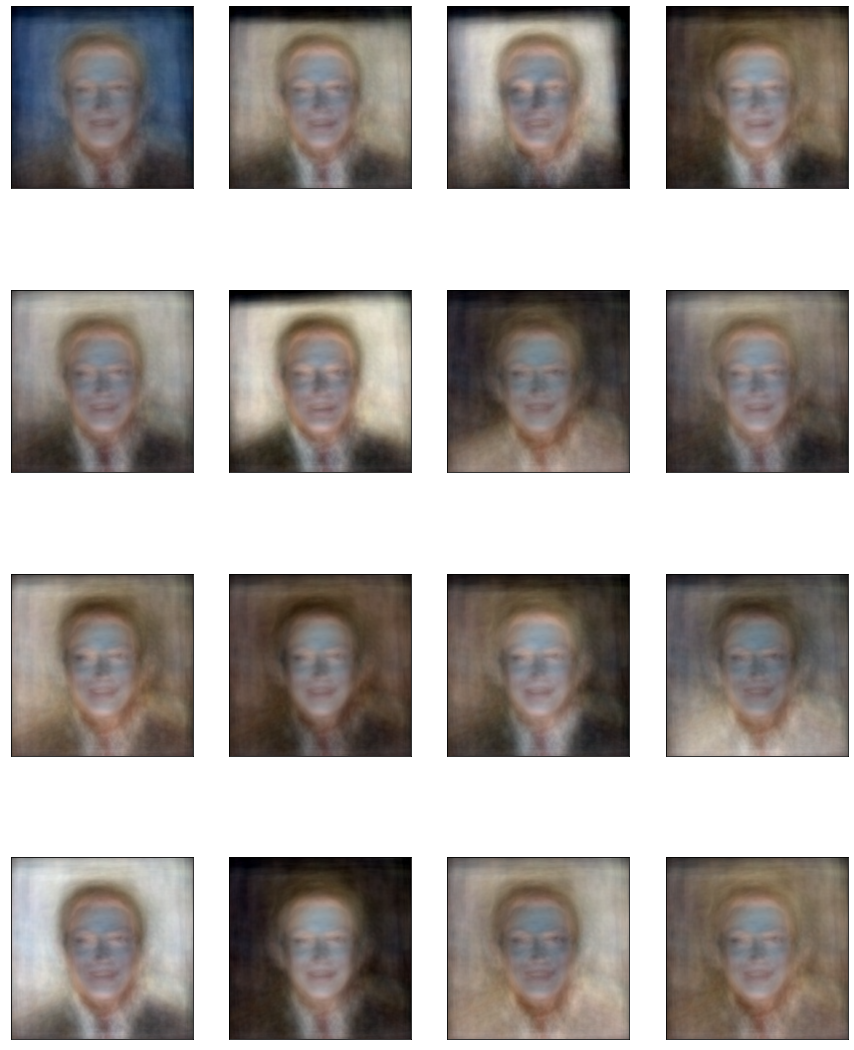

In [23]:
# plot
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,20))
ax = ax.flatten()

for i in range(16):
    ax[i].imshow(centroids_train_40[i].reshape(250, 250, 3))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show(fig)

### 3.4. (Extra Credit): Recognition

Create a set of 10 images using (i) 8 images randomly selected from the test data, (ii)  any other non-face image you can find that has the right dimensions, and (iii) an image of yourself. Create a 10 x 5 grid of images, with one row for each of these images, and 5 columns that contain: 
1. The original image. 
2. The reconstruction of that image after it is projected onto the 40-dimensional eigenface-space and then re-projected back into the original image space. 
3. Find the nearest centroid (from 3.3) to the image, and show the reconstruction of that nearest centroid. 
4. Find the image in the training data whose 40-dimensional representation is closest to that centroid, and show the reconstruction of that image.
5. Show the original training image that was selected in above (step 4 in this list)

Post the five images corresponding to your headshot on piazza to share with the rest of the class.

In [24]:
# set up the test images array
test_imgs = np.zeros((10, 187500))

# 8 from the test set
test_inds = np.random.choice(np.shape(X_test)[0], 8, replace=False)
for i in range(len(test_inds)):
    test_imgs[i] = X_test[test_inds[i]].copy()

# object image
test_imgs[8] = mpimg.imread('arduino.jpg').reshape((1, 250*250*3))/255

# my image
test_imgs[9] = daniel/255

In [25]:
# there
test_imgs_40 = test_imgs.dot(pc_40.T)

# and back again
test_imgs_40 = test_imgs_40.dot(pc_40)

In [26]:
closest_centroids_train_40 = pairwise_distances_argmin(test_imgs_40, centroids_train_40, metric='euclidean')

In [27]:
closest_neighbours_train_40 = pairwise_distances_argmin(centroids_train_40[closest_centroids_train_40],
                                                        X_train_40.dot(pc_40),
                                                        metric='euclidean')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

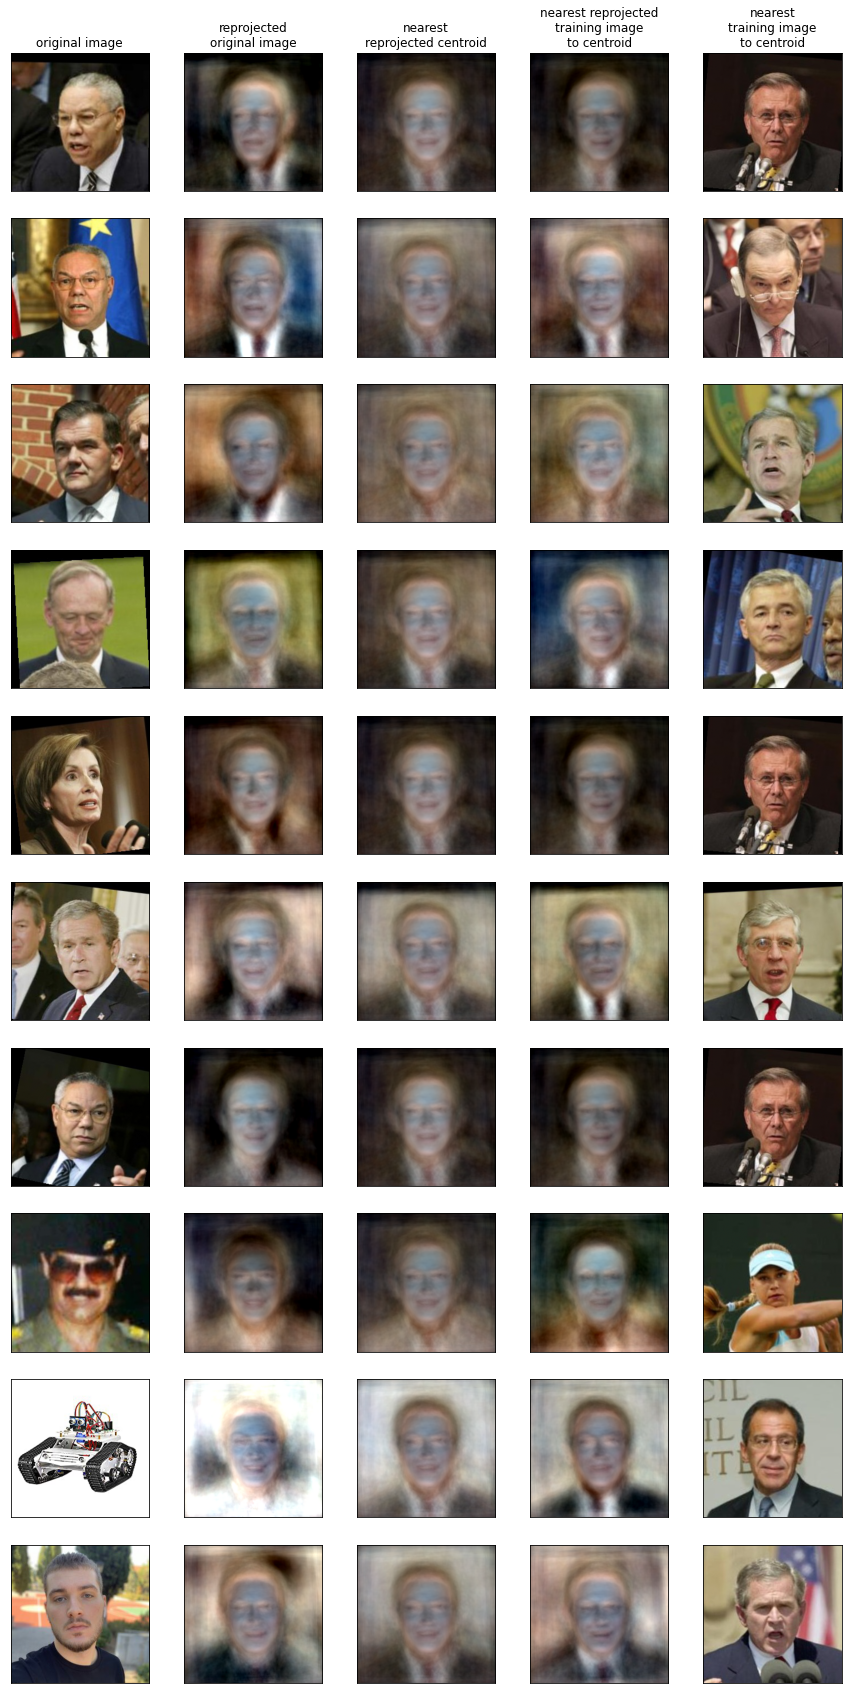

In [28]:
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(15,30))

for i in range(10):
    ax[i][0].imshow(test_imgs[i].reshape(250, 250, 3))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    
    ax[i][1].imshow(test_imgs_40[i].reshape(250, 250, 3))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    
    ax[i][2].imshow(centroids_train_40[closest_centroids_train_40[i]].reshape(250, 250, 3))
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    
    ax[i][3].imshow(X_train_40.dot(pc_40)[closest_neighbours_train_40[i]].reshape(250, 250, 3))
    ax[i][3].set_xticks([])
    ax[i][3].set_yticks([])
    
    ax[i][4].imshow(X_train[closest_neighbours_train_40[i]].reshape(250, 250, 3))
    ax[i][4].set_xticks([])
    ax[i][4].set_yticks([])
    
ax[0][0].set_title('original image')
ax[0][1].set_title('reprojected\noriginal image')
ax[0][2].set_title('nearest\nreprojected centroid')
ax[0][3].set_title('nearest reprojected\ntraining image\nto centroid')
ax[0][4].set_title('nearest\ntraining image\nto centroid')
    
plt.show(fig)

# 4. Deep Learning

### 4.1 Data preprocessing
1. For this problem, filter to images associated with people that have at least 100 images in the dataset. Use the color version of the images (not grayscale). We'll use this dataset for a supervised multiclass classification problem, classifying which person each image is. How many classes (people) are there? How many observations (images) are there total?

2. Divide the reduced dataset into 50% train and 50% test. Standardize the data.

In [83]:
image_df = image_df[image_df['n']>=100]
image_df.reset_index(drop=True, inplace=True)
print('number of remaining people = {}'.format(len(image_df.index)))
print('number of remaining images = {}'.format(np.sum(image_df['n'])))

number of remaining people = 5
number of remaining images = 1140.0


In [84]:
image_df

n               name
0  236.0       Colin_Powell
1  121.0    Donald_Rumsfeld
2  530.0      George_W_Bush
3  109.0  Gerhard_Schroeder
4  144.0         Tony_Blair

In [73]:
# import numpy as np
# import pandas as pd
# from sklearn.datasets import fetch_lfw_people
 
# faces = fetch_lfw_people(min_faces_per_person=100)
# image_count = faces.images.shape[0]
# image_height = faces.images.shape[1]
# image_width = faces.images.shape[2]
# class_count = len(faces.target_names)
  
# faces = fetch_lfw_people(min_faces_per_person=100)
# print(faces.target_names)
# print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


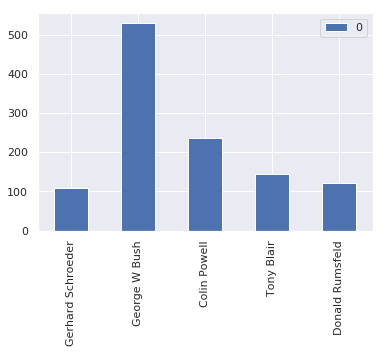

In [75]:
from collections import Counter
counts = Counter(faces.target)
names = {}
  
for key in counts.keys():
    names[faces.target_names[key]] = counts[key]
  
df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

In [76]:
mask = np.zeros(faces.target.shape, dtype=np.bool)
  
for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
      
x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces.shape

(500, 2914)

In [77]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
 
face_images = x_faces / 255
face_labels = to_categorical(y_faces)
                              
x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.5, stratify=face_labels, random_state=0)

### 4.2 Naive baseline
As a naive baseline method to compare to, create a random ordering of the labels in the training set and the test set. Report the overall classification accuracy for the shuffled labels in comparison to the true labels. Also report the true positive rate for each class. This random baseline represents a naive classifier that guesses randomly among the classes. What do you notice about the differences in precision and recall across classes?

In [85]:
# Convert image data to numpy array
#Reading all Images
from skimage import io

all_data = []
for i in range(len(image_df['name'])):
    person=image_df['name'][i]
    req_dir = image_root + '/' + person
    imageList = [name for name in os.listdir(req_dir)]
    for image_name in imageList:
        all_data.append(io.imread(os.path.join(req_dir, image_name)))

all_data = np.array(all_data[1:]) # convert list to array

In [86]:
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score

In [87]:
recall_list = []
for i in range(0, 5):
    col_arr = np.array(all_data[i])
    false_neg = col_arr.sum()
    true_pos = 100 * (all_data[i][i]/false_neg)
    recall_list.append(true_pos)
    
print("True Positive Rates (Precision)")
recall_list

True Positive Rates (Precision)


[array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.000

In [88]:
cm_matrix = np.matrix(all_data.T)
col_sum = cm_matrix.sum(axis=1)
true_pos_list = []
for i in range(0, 5):
    true_pos = 100 * (all_data[i][i]/col_sum[i])
    true_pos_list.append(true_pos)
    
print("True Positive Rates (Recall)")
true_pos_list

### 4.3 Feed forward neural network
Reshape your X data so that each observation is flattened into a 1d array, and each of the training and test matrices are 2d arrays. The shape of your data should be n_observations X 187,500. Train a fully connected neural network to predict which class each observation is in. The input_dimensions of your network will be 187,500 for each of the 187,500 "features" obtained from the flattened images. You are responsible for determining the structure of the network, the activiation functions, regularization, and optmization techniques. Ensure that your network exceeds 70% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the naive baseline?

*Hint: If you're not sure where to start, consider revisiting labs 8 and 10.*

In [78]:
from keras.layers import Dense
from keras.models import Sequential
 
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(image_width * image_height,)))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               1492480   
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 2565      
Total params: 1,495,045
Trainable params: 1,495,045
Non-trainable params: 0
_________________________________________________________________


In [80]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=60, batch_size=25)

Train on 250 samples, validate on 250 samples
Epoch 1/60
250/250 [==============================] - 2s 10ms/step - loss: 1.0362 - acc: 0.6440 - val_loss: 1.2968 - val_acc: 0.4600
Epoch 2/60
250/250 [==============================] - 3s 12ms/step - loss: 1.0918 - acc: 0.5520 - val_loss: 1.2953 - val_acc: 0.4960
Epoch 3/60
250/250 [==============================] - 3s 13ms/step - loss: 1.1363 - acc: 0.5960 - val_loss: 1.6715 - val_acc: 0.3640
Epoch 4/60
250/250 [==============================] - 4s 16ms/step - loss: 1.1451 - acc: 0.5360 - val_loss: 1.4657 - val_acc: 0.4800
Epoch 5/60
250/250 [==============================] - 5s 18ms/step - loss: 1.0789 - acc: 0.5800 - val_loss: 1.4878 - val_acc: 0.4480
Epoch 6/60
250/250 [==============================] - 5s 20ms/step - loss: 1.0690 - acc: 0.5920 - val_loss: 1.1955 - val_acc: 0.5800
Epoch 7/60
250/250 [==============================] - 4s 17ms/step - loss: 1.0693 - acc: 0.6040 - val_loss: 1.3723 - val_acc: 0.4800
Epoch 8/60
250/250 [===

Text(89.18, 0.5, 'Actual label')

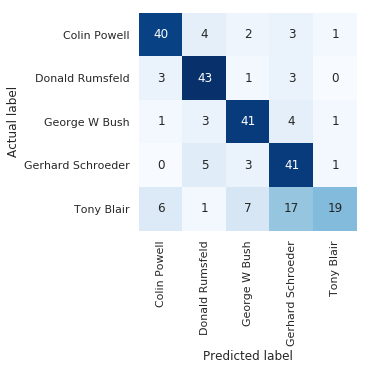

In [82]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

### Discussion

As we can see from the application of the neural network we got an accuracy of ~ 90%

- The confussion matrix shows us the ratio of true positives and true negatives, from which we are able to compute precision and recall.

### 4.4 Convolutional neural network

Now, train a convolutional neural network to predict which person is in each image. As above, you are in charge of all design parameters for the network, including convolutional filters, pooling layers, regularization, and optimization. Ensure that your CNN achieves over 80% overall classification accuracy on the test set. Report the classification accuracy on the test set, along with the precision and recall for each class. What do you notice about the precision and recall values, as well as the overall classification accuracy, in comparison to the feed forward neural network and naive baseline?

*Hint: If you're not sure where to start, consider revisiting lab 10.*

In [92]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
 
face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)
 
x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.5, stratify=face_labels, random_state=0)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(face_images.shape[1:])))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=10)

![epoch](epochs.png)